In [ ]:
# # 尝试使用gpu加速
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# # device = "cpu"
# print("device: ", device)
# # print("这里可以用mps加速，但是实测下来，由于网络太小了，gpu并行计算优势不大，不如cpu速度快。")

# # 数据预处理函数
# def preprocess_data(smp_data):
#     # 处理数值特征
#     numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()
#     numeric_features.remove('label')
#     scaler = StandardScaler()
#     smp_data[numeric_features] = scaler.fit_transform(smp_data[numeric_features])

#     # 获取类别特征
#     categorical_columns = smp_data.select_dtypes(include=['object']).columns.tolist()
    
#     # 对类别特征使用LabelEncoder
#     label_encoder = LabelEncoder()
#     for column in categorical_columns:
#         smp_data[column] = label_encoder.fit_transform(smp_data[column].fillna('missing').astype(str))

#     return smp_data, numeric_features, categorical_columns

# # 预处理数据
# smp_data, numeric_features, categorical_columns = preprocess_data(smp_data)

# # 特征和标签
# Y = smp_data['label']
# X_image = smp_data[['category', 'subcategory', 'red_mean', 'green_mean', 'blue_mean', 'red_std', 
#                     'green_std', 'blue_std', 'hue_mean', 'saturation_mean', 'value_mean', 'hue_std', 
#                     'saturation_std', 'value_std', 'contrast', 'homogeneity', 'energy', 'entropy', 
#                     'correlation', 'ASM', 'dissimilarity',]]
# X_text = smp_data[['user_description', 'all_tags', 'title', 'title_char_count', 'title_word_count', 
#                     'title_avg_word_length', 'title_punctuation_count', 'title_uppercase_count', 
#                     'title_digit_count', 'title_stopword_ratio', 'title_noun_ratio', 'title_verb_ratio', 
#                     'title_unique_word_ratio', 'title_avg_sentence_length', 'user_description_char_count', 
#                     'user_description_word_count', 'user_description_avg_word_length', 
#                     'user_description_punctuation_count', 'user_description_uppercase_count', 
#                     'user_description_digit_count', 'user_description_stopword_ratio', 
#                     'user_description_noun_ratio', 'user_description_verb_ratio', 
#                     'user_description_unique_word_ratio', 'user_description_avg_sentence_length', 
#                     'all_tags_char_count', 'all_tags_word_count', 'all_tags_avg_word_length', 
#                     'all_tags_punctuation_count', 'all_tags_digit_count', 'all_tags_stopword_ratio', 
#                     'all_tags_noun_ratio', 'all_tags_verb_ratio', 'all_tags_unique_word_ratio', 
#                     'all_tags_avg_sentence_length', 'all_tags_punctuation_count_spv', 
#                     'all_tags_unique_word_ratio_spv', 'all_tags_stopword_ratio_spv', 'title_verb_ratio_spv', 
#                     'title_unique_word_ratio_spv']]
# X_user = smp_data[['Uid', 'Postdate', 'Longitude', 'Geoaccuracy', 'Latitude', 'photo_firstdate', 
#                     'photo_count', 'ispro', 'timezone_offset', 'photo_firstdatetaken', 'timezone_id', 
#                     'media_type', 'Longitude_spv', 'Geoaccuracy_spv', 'Latitude_spv', 'photo_firstdate_spv',]]


# # 获取数值特征
# numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()

# # 将类别和数值特征分开
# X = {  
#     'image': {'category': [feat for feat in X_image.columns if feat not in numeric_features], 
#               'numeric': [feat for feat in X_image.columns if feat in numeric_features]},
#     'text': {'category': [feat for feat in X_text.columns if feat not in numeric_features],
#              'numeric': [feat for feat in X_text.columns if feat in numeric_features]},
#     'user': {'category': [feat for feat in X_user.columns if feat not in numeric_features],
#              'numeric': [feat for feat in X_user.columns if feat in numeric_features]}
# }
# X_feat_name = {
#     key: [] for key in X.keys()
# }
# X_feat_name_full = []
# for key, value in X.items():
#     for name in value['category']:
#         X_feat_name[key].extend([name] * 16)
#         X_feat_name_full.extend([f"{name}_{i}" for i in range(16)])
#     for name in value['numeric']:
#         X_feat_name[key].extend([name])

# # 类别特征使用Embedding层
# class CategoryEmbedding(nn.Module):
#     def __init__(self, input_dim, embedding_dim):
#         super(CategoryEmbedding, self).__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
#         # 使用更稳健的初始化方法
#         init.kaiming_normal_(self.embedding.weight, mode='fan_out', nonlinearity='relu')
    
#     def forward(self, x):
#         return self.embedding(x)

# # 将类别特征编码为Embedding
# def encode_category_features_with_embedding(df, features, embedding_dim=16):
#     encoded_features = {}
#     label_encoder = LabelEncoder()
    
#     for feature in features:
#         # 对每个类别特征进行编码
#         encoded = label_encoder.fit_transform(df[feature].fillna('missing').astype(str))
        
#         # 存储嵌入层
#         embedding_layer = CategoryEmbedding(len(label_encoder.classes_), embedding_dim)
#         # 转化为张量并通过Embedding层
#         encoded_tensor = torch.tensor(encoded, dtype=torch.long)
#         embedded_feature = embedding_layer(encoded_tensor)
        
#         # 将嵌入后的特征存储
#         encoded_features[feature] = embedded_feature
    
#     return encoded_features

# # 对类别特征进行编码
# X_image_encoded = encode_category_features_with_embedding(X_image, X['image']['category'], embedding_dim=16)
# X_text_encoded = encode_category_features_with_embedding(X_text, X['text']['category'], embedding_dim=16)
# X_user_encoded = encode_category_features_with_embedding(X_user, X['user']['category'], embedding_dim=16)

# # 数值特征无需处理，直接保留
# X_image_numeric = torch.tensor(X_image[X['image']['numeric']].values, dtype=torch.float32)
# X_text_numeric = torch.tensor(X_text[X['text']['numeric']].values, dtype=torch.float32)
# X_user_numeric = torch.tensor(X_user[X['user']['numeric']].values, dtype=torch.float32)

# # 合并所有特征（类别特征和数值特征）
# X_image_final = torch.cat([*X_image_encoded.values(), X_image_numeric], dim=1)
# X_text_final = torch.cat([*X_text_encoded.values(), X_text_numeric], dim=1)
# X_user_final = torch.cat([*X_user_encoded.values(), X_user_numeric], dim=1)
# image_dim = X_image_final.shape[1]
# text_dim = X_text_final.shape[1]
# user_dim = X_user_final.shape[1]

# # 最终的训练数据，将三个部分拼接起来
# X_final = torch.cat([X_image_final, X_text_final, X_user_final], dim=1)
# print(X_final.shape)

# # 填充na值
# tensor_mean = torch.nanmean(X_final, dim=0)  # 按列计算均值
# for i in range(X_final.size(1)):  # 遍历每一列
#     X_final[:, i][torch.isnan(X_final[:, i])] = tensor_mean[i]

# # 训练和测试数据分割
# X_train, X_test, y_train, y_test = train_test_split(X_final, Y, test_size=0.2, random_state=42)

# # 转换为 PyTorch tensor
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# # 打印训练和测试数据的形状
# print(f'X_train shape: {X_train_tensor.shape}')
# print(f'X_test shape: {X_test_tensor.shape}')

# # 定义数据集和数据加载器
# class CustomDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = features
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
# test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# batch_size = 4096
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
# print("batch_size:", batch_size)

device:  mps
torch.Size([305613, 212])
X_train shape: torch.Size([244490, 212])
X_test shape: torch.Size([61123, 212])
batch_size: 4096


In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')
from utils import *
import configs
low_level_feature_file = "smp_all_set_llfeat_0312.pkl"
globals().update(dill.load(open(low_level_feature_file, "rb")))

/var/folders/w9/pwn3f5_956q3433d95gyj2900000gn/T/ipykernel_69999/960570486.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')
/Users/bytedance/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bytedance/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /Users/bytedance/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <D983C0C6-7C01-3D9C-A96B-07BB20D2CE66> /Users/bytedance/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/bytedance/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Pleas

mask:  7


Training model main_model: 100%|██████████| 800/800 [1:36:53<00:00,  7.27s/it, test_loss=1.5463, train_loss=1.3998]


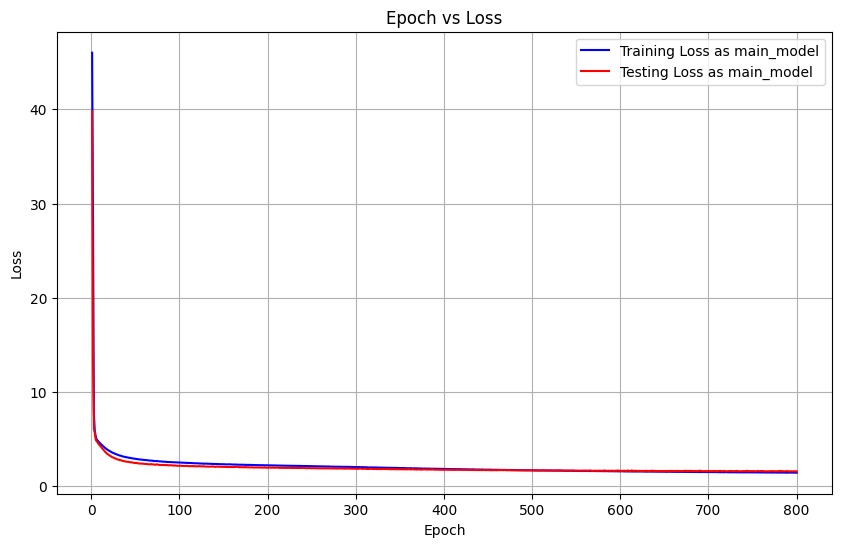

Correlation between actual labels and predicted values at main_model: 0.8751545327325155
Mean Absolute Error (MAE) at main_model: 0.7967833280563354
mask:  6


Training model main_model: 100%|██████████| 800/800 [1:39:31<00:00,  7.46s/it, test_loss=1.6770, train_loss=1.7533]


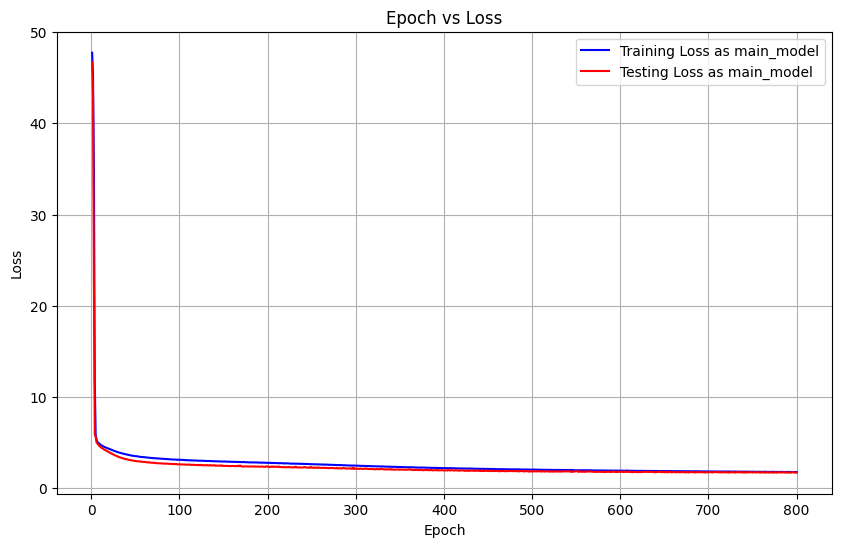

Correlation between actual labels and predicted values at main_model: 0.8611027976467448
Mean Absolute Error (MAE) at main_model: 0.8554590344429016
mask:  5


Training model main_model: 100%|██████████| 800/800 [1:39:03<00:00,  7.43s/it, test_loss=2.0849, train_loss=2.2751]


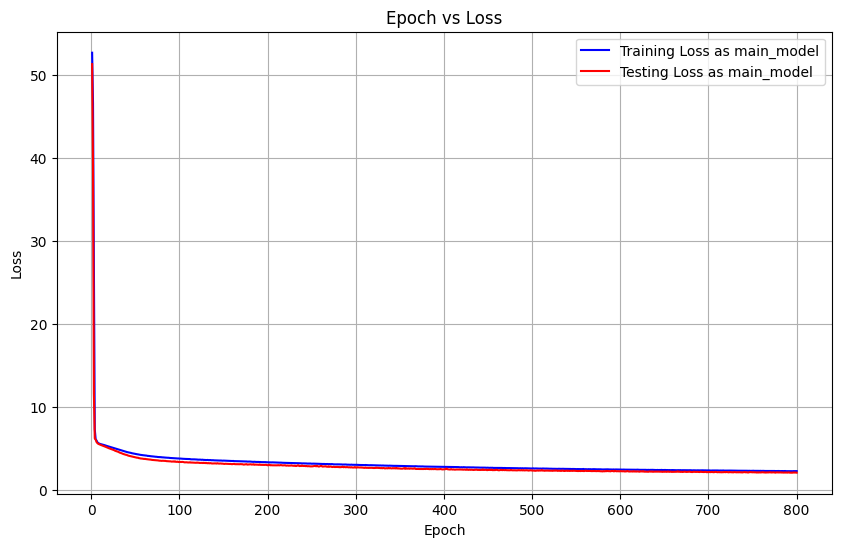

Correlation between actual labels and predicted values at main_model: 0.8235700182113219
Mean Absolute Error (MAE) at main_model: 0.9733268022537231
mask:  4


Training model main_model: 100%|██████████| 800/800 [1:36:28<00:00,  7.24s/it, test_loss=2.6404, train_loss=3.1008]


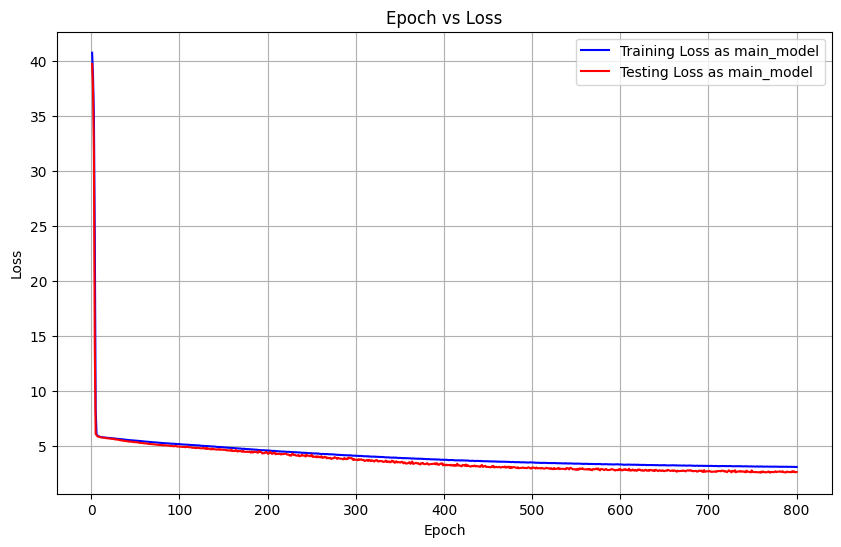

Correlation between actual labels and predicted values at main_model: 0.7692347573888465
Mean Absolute Error (MAE) at main_model: 1.1243728399276733
mask:  3


Training model main_model: 100%|██████████| 800/800 [1:44:10<00:00,  7.81s/it, test_loss=2.1208, train_loss=2.2625]


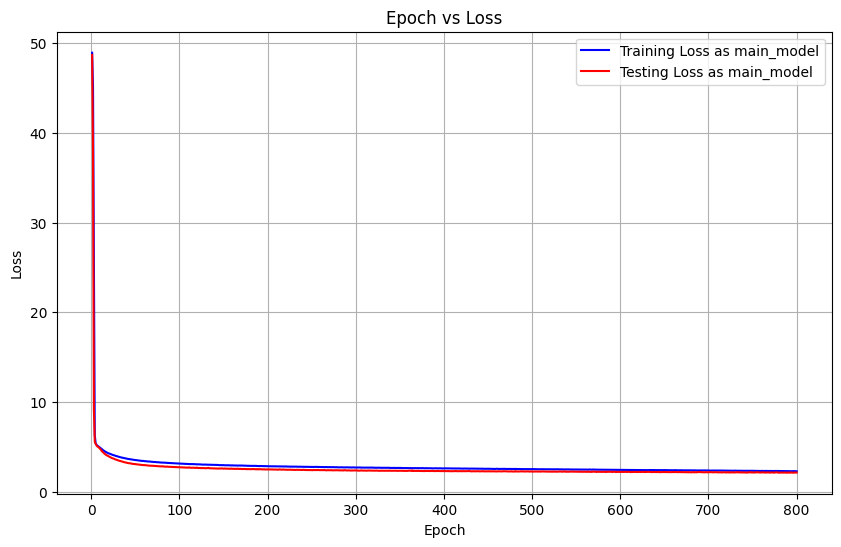

Correlation between actual labels and predicted values at main_model: 0.8180899792251929
Mean Absolute Error (MAE) at main_model: 0.9878225326538086
mask:  2


Training model main_model: 100%|██████████| 800/800 [1:39:53<00:00,  7.49s/it, test_loss=2.7989, train_loss=3.2567]


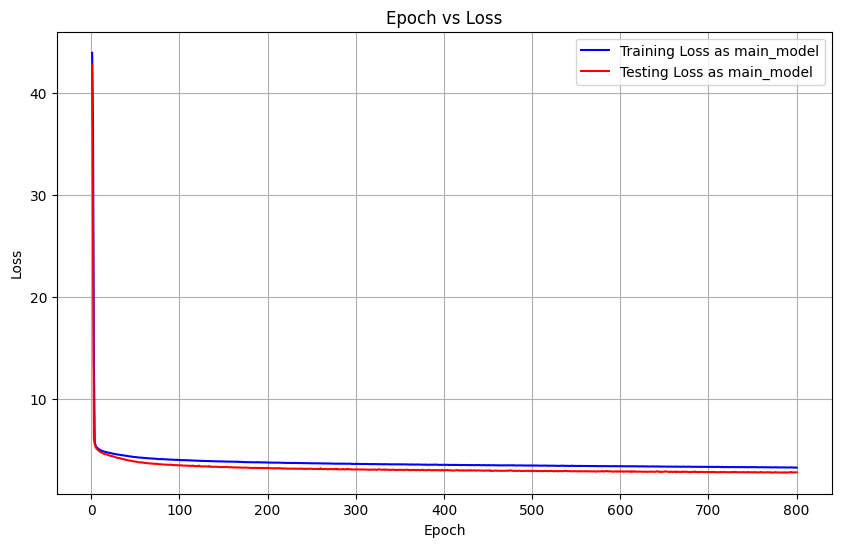

Correlation between actual labels and predicted values at main_model: 0.7452794587408071
Mean Absolute Error (MAE) at main_model: 1.161919355392456
mask:  1


Training model main_model: 100%|██████████| 800/800 [1:37:21<00:00,  7.30s/it, test_loss=4.9941, train_loss=5.0221]


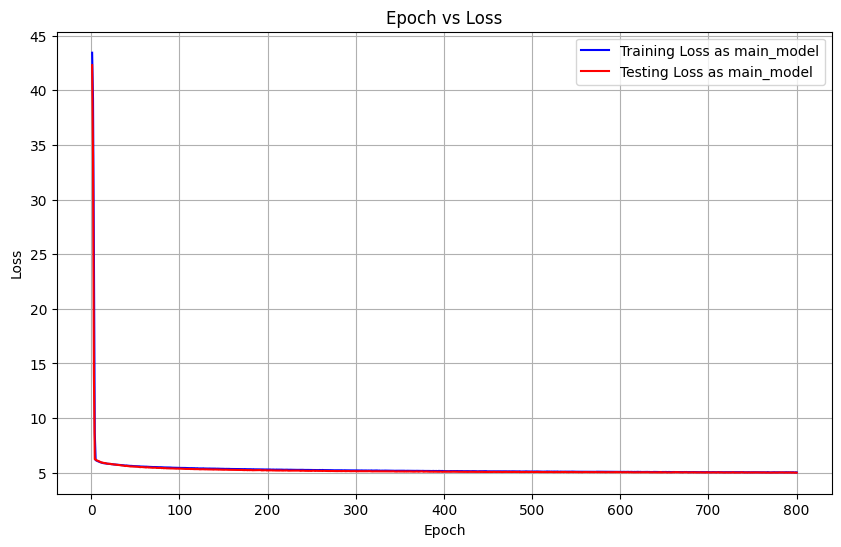

Correlation between actual labels and predicted values at main_model: 0.4224204224139433
Mean Absolute Error (MAE) at main_model: 1.7146118879318237
mask:  7


Training model wo_dropoout_model: 100%|██████████| 800/800 [1:37:38<00:00,  7.32s/it, test_loss=1.9344, train_loss=0.5227]


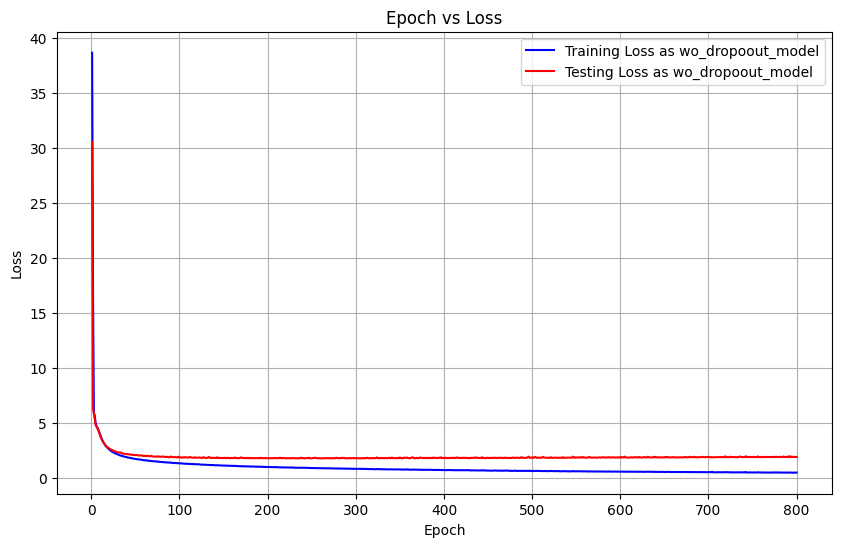

Correlation between actual labels and predicted values at wo_dropoout_model: 0.8475354231752917
Mean Absolute Error (MAE) at wo_dropoout_model: 0.8444712162017822
mask:  7


Training model wo_residual_model: 100%|██████████| 800/800 [1:29:57<00:00,  6.75s/it, test_loss=1.5570, train_loss=1.3944]


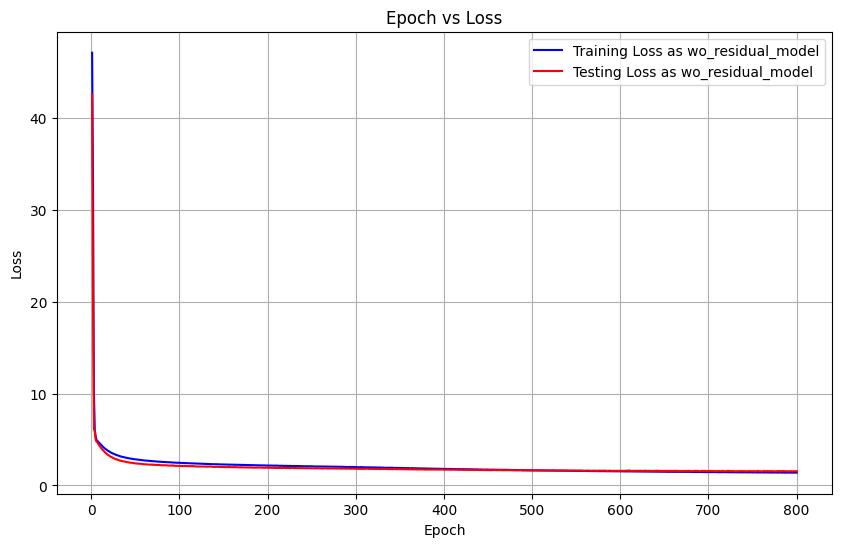

Correlation between actual labels and predicted values at wo_residual_model: 0.8742238964250792
Mean Absolute Error (MAE) at wo_residual_model: 0.804411768913269
mask:  7


Training model wo_transformermlp_model: 100%|██████████| 800/800 [1:23:50<00:00,  6.29s/it, test_loss=4.7649, train_loss=4.9381] 


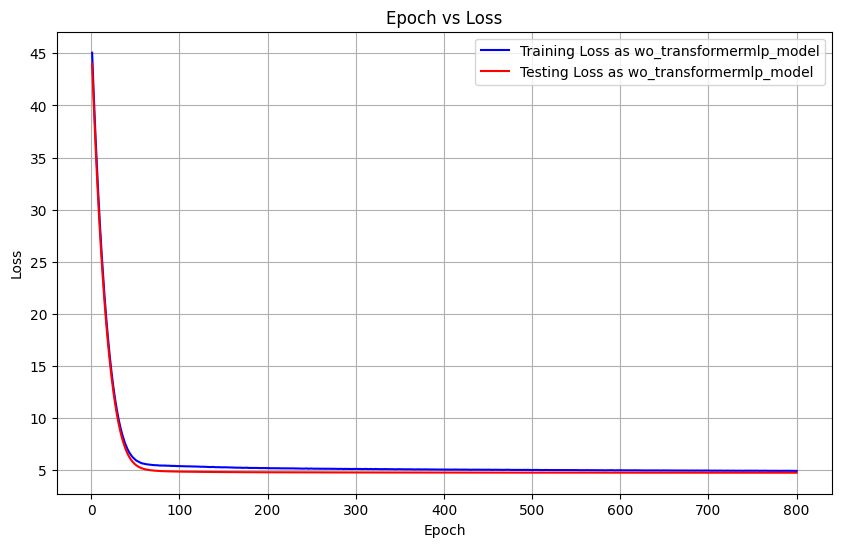

Correlation between actual labels and predicted values at wo_transformermlp_model: 0.4681196912964464
Mean Absolute Error (MAE) at wo_transformermlp_model: 1.7244951725006104
mask:  7


Training model wo_transformer_model: 100%|██████████| 800/800 [1:25:48<00:00,  6.44s/it, test_loss=2.2058, train_loss=2.4865]


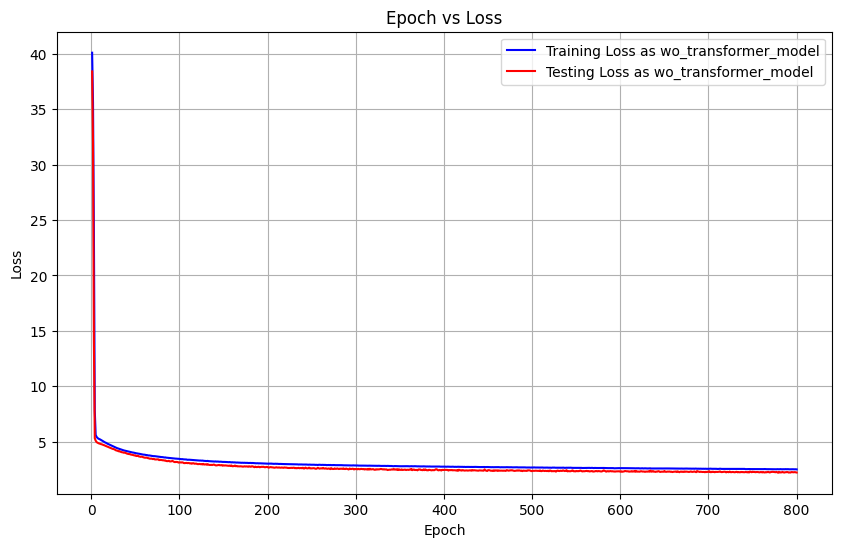

Correlation between actual labels and predicted values at wo_transformer_model: 0.8076644103212041
Mean Absolute Error (MAE) at wo_transformer_model: 1.010514736175537
mask:  7


Training model wo_mlp_model: 100%|██████████| 800/800 [1:32:56<00:00,  6.97s/it, test_loss=1.6715, train_loss=1.5753]


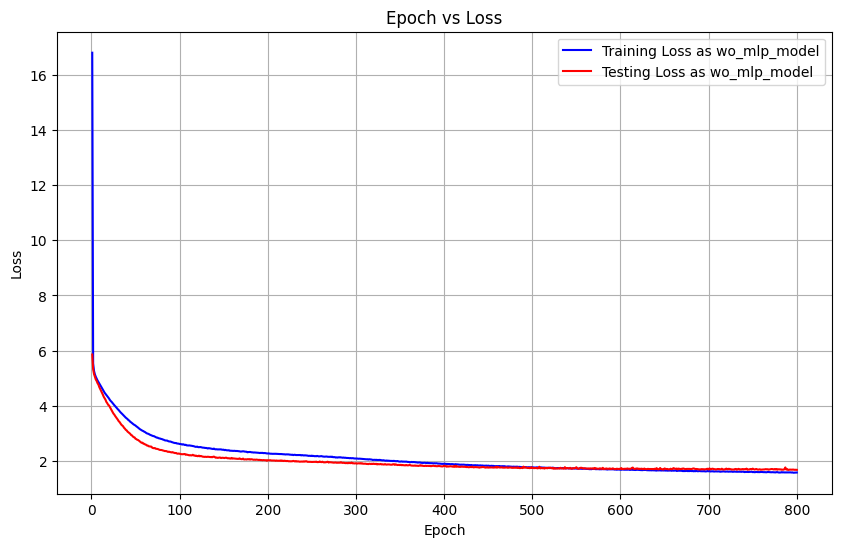

Correlation between actual labels and predicted values at wo_mlp_model: 0.8704623702663381
Mean Absolute Error (MAE) at wo_mlp_model: 0.8866460919380188
mask:  7


Training model wo_seblock_model: 100%|██████████| 800/800 [1:32:06<00:00,  6.91s/it, test_loss=1.7800, train_loss=1.8482]


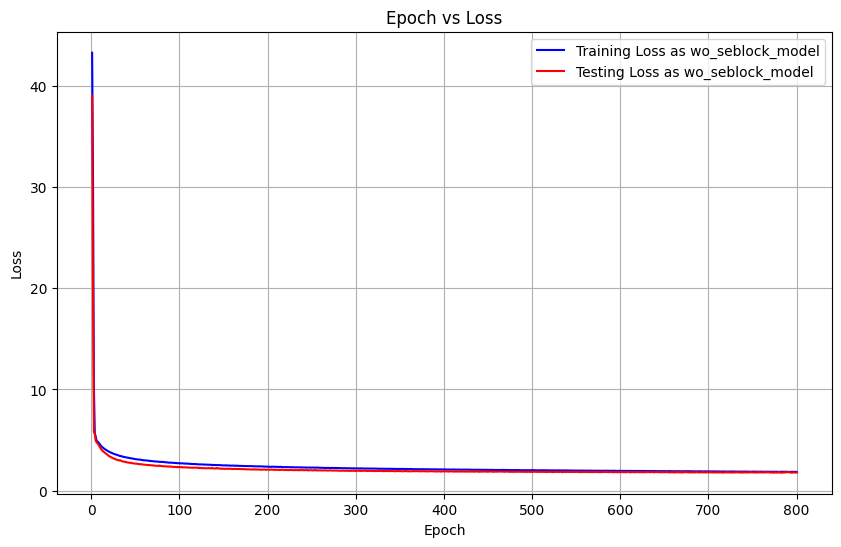

Correlation between actual labels and predicted values at wo_seblock_model: 0.8502138974208855
Mean Absolute Error (MAE) at wo_seblock_model: 0.8866831064224243


In [7]:
models = [AllinOneMLP, WithoutDropout, WithoutResidual, WithoutTransformerMLP, WithoutTransformer, WithoutMLP, WithoutSEBlock]
model_names = ["main_model", "wo_dropoout_model", "wo_residual_model", "wo_transformermlp_model", "wo_transformer_model", "wo_mlp_model", "wo_seblock_model"]
masks = [list(range(7, 0, -1))] + [[7] for _ in models[1:]]
save_file_prefix = "48"
train_list = [
    {
        "model_class": models[i],
        "image_dim": image_dim, 
        "text_dim": text_dim, 
        "user_dim": user_dim, 
        "train_loader": train_loader, 
        "test_loader": test_loader, 
        "device": device, 
        "save_file_prefix": save_file_prefix, 
        "model_name": model_names[i],
        "masks": masks[i],
        "X_test_tensor": X_test_tensor,
        "y_test_tensor": y_test_tensor,
        "ckpt_gap": 100,
        "num_epochs": 800
    } for i in range(len(models))
]

losses = []

for train in train_list:
    results = train_and_evaluate(**train)
    losses.extend(results)

In [6]:
print(losses)

[[[40.66588223775228, 29.053861776987713], [37.04623311360677, 16.361679077148438]], [[46.958058230082194, 38.646437136332196], [44.06893641153972, 30.47345542907715]], [[48.12330118815104, 36.03674736022949], [43.882694498697916, 24.381770197550455]], [[46.907997131347656, 35.40633347829183], [42.85118916829427, 24.009495798746745]], [[45.5062473932902, 32.318386967976885], [41.95829849243164, 17.248751068115233]], [[43.2893144607544, 40.248538144429524], [42.33644790649414, 36.66512959798177]], [[48.25750942230225, 36.07246179580689], [45.00855331420898, 21.498816808064777]], [[44.81626847585042, 26.341233269373575], [38.87870864868164, 11.82149461110433]], [[41.900479443868, 15.319846844673156], [29.650741831461588, 6.156269709269206]], [[48.936706670125325, 46.57228132883708], [47.83105214436849, 45.5243423461914]], [[46.50710474650065, 42.030207824707034], [44.9902946472168, 37.89543787638346]], [[16.84419383207957, 5.603248699506124], [5.99398733774821, 5.336724313100179]], [[39.

In [103]:
import shap
import torch
import numpy as np
import pandas as pd

sample_size = 4096 * 8  # 采样数量
K_means_k = 128
mask = 7

# 使用DeepExplainer替换KernelExplainer
def get_shap_values(model, X_train_tensor, X_test_tensor, mask, sample_size=100, K_means_k=10, device='cuda'):
    # 准备背景数据（直接使用采样后的tensor，无需KMeans）
    background_indices = np.random.choice(len(X_train_tensor), size=min(sample_size, len(X_train_tensor)), replace=False)
    background_data = get_input(X_train_tensor[background_indices], mask).to(device)

    # 初始化 GradientExplainer
    explainer = shap.GradientExplainer(model, background_data)

    # 准备测试数据（保持tensor格式）
    test_indices = np.random.choice(len(X_test_tensor), size=min(sample_size, len(X_test_tensor)), replace=False)
    test_data = get_input(X_test_tensor[test_indices], mask).to(device)

    # 计算SHAP值（自动处理设备转换）
    shap_values = explainer.shap_values(test_data)

    # 处理输出格式
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)
    
    # 调整维度 (假设单输出模型)
    shap_values = shap_values.squeeze(axis=2) if len(shap_values.shape) == 3 else shap_values
    print(f"SHAP值原始维度: {shap_values.shape}")

    # 保存中间结果
    pd.DataFrame(shap_values).to_csv(f'shap_values_{save_file_prefix}_mask_{mask}_before.csv', index=False)

    # 计算特征重要性均值
    mean_shap = np.mean(shap_values, axis=0)
    result_df = pd.DataFrame(mean_shap, columns=["shap_value"])

    # 添加特征名称
    feat_names = []
    if mask & 0b001:  # 更易读的位运算
        feat_names.extend(X_feat_name['image'])
    if mask & 0b010:
        feat_names.extend(X_feat_name['text'])
    if mask & 0b100:
        feat_names.extend(X_feat_name['user'])
    
    result_df['feature'] = feat_names
    result_df.to_csv(f'shap_values_{save_file_prefix}_mask_{mask}_after.csv', index=False)
    return result_df


# 转换为评估模式
model = AllinOneMLP(image_dim, text_dim, user_dim, 7).to(device)
model.load_state_dict(torch.load(f'model_testing_mask_7_{save_file_prefix}.pt'))
model.eval()
shap_values = get_shap_values(model, X_train_tensor, X_test_tensor, 7, sample_size=sample_size, K_means_k=K_means_k, device=device)

# 按A列分组并计算B列的均值，重置索
result = shap_values.groupby('feature', sort=False)['shap_value'].mean().reset_index()
result['shap_value'] = result['shap_value'].abs()
result = result.sort_values(by='shap_value', ascending=False)

# 打印结果
print(result)

# 可选：将结果保存到新CSV文件
result.to_csv(f'output_{save_file_prefix}.csv', index=False)

SHAP值原始维度: (32768, 212)
                         feature  shap_value
47           all_tags_word_count    0.004671
40  user_description_digit_count    0.002718
36   user_description_word_count    0.002584
62                         ispro    0.002549
35   user_description_char_count    0.002240
..                           ...         ...
17                       entropy    0.000031
53           all_tags_verb_ratio    0.000028
75                  Latitude_spv    0.000025
2                       red_mean    0.000016
32              title_verb_ratio    0.000013

[77 rows x 2 columns]


number of parameters:  448632


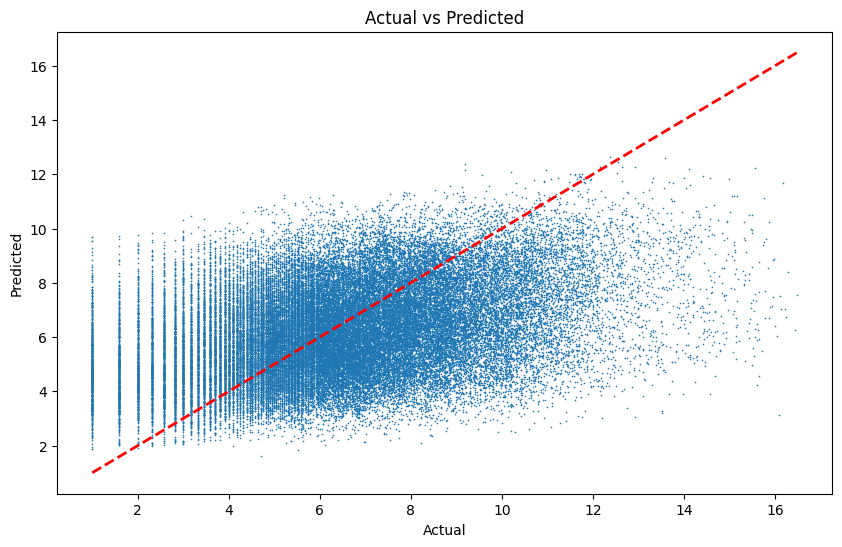

In [118]:
import random

import matplotlib.pyplot as plt

# 使用模型进行预测
model = AllinOneMLP(image_dim, text_dim, user_dim, 7).to(device)
model.load_state_dict(torch.load(f'model_testing_mask_7_{save_file_prefix}.pt'))
num_params = sum(p.numel() for p in model.parameters())
print("number of parameters: ", num_params)
model.eval()
with torch.no_grad():
    X_test_tensor_scatter_preds = model(get_input(X_test_tensor, 7))

# 将预测结果与实际值进行比较，并可视化
X_test_tensor_scatter_preds = X_test_tensor_scatter_preds.cpu().numpy()
# y_train_tensor = y_train_tensor.numpy()

# 可视化回归结果
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.to("cpu"), X_test_tensor_scatter_preds, alpha=1, linewidths=0.1, s=1)
plt.plot([y_test_tensor.to("cpu").min(), y_test_tensor.to("cpu").max()], [y_test_tensor.to("cpu").min(), y_test_tensor.to("cpu").max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Training model wo_dropoout_model: 100%|██████████| 800/800 [1:37:52<00:00,  7.34s/it, test_loss=1.9448, train_loss=0.5706]


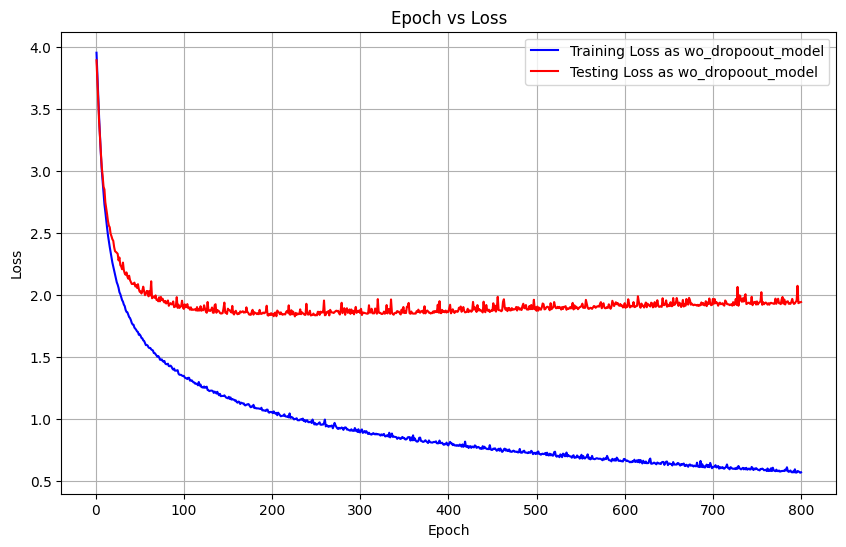

Test Loss: 1.8284155448277792
Correlation between actual labels and predicted values at wo_dropoout_model: 0.8445114282770005
Mean Absolute Error (MAE) at wo_dropoout_model: 0.8587974309921265


Training model wo_residual_model: 100%|██████████| 800/800 [2:20:46<00:00, 10.56s/it, test_loss=1.5416, train_loss=1.3700]    


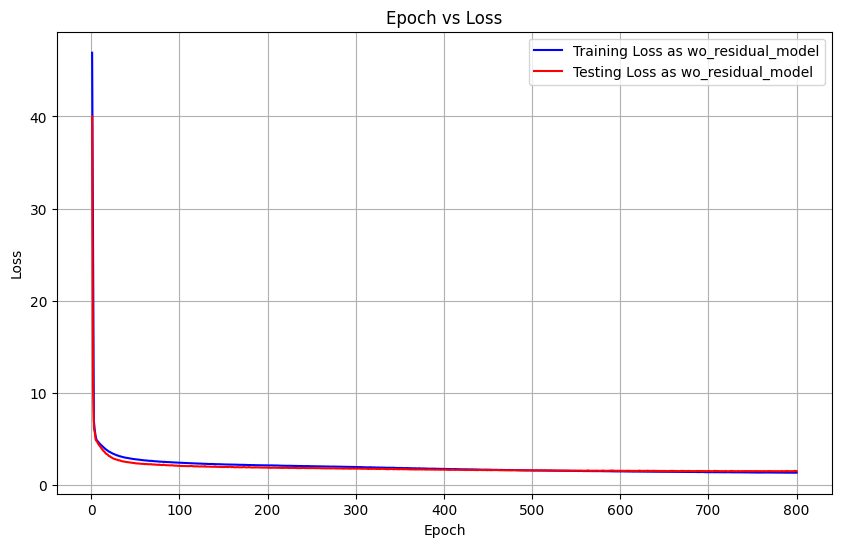

Test Loss: 1.5160085360209148
Correlation between actual labels and predicted values at wo_residual_model: 0.8748042316194761
Mean Absolute Error (MAE) at wo_residual_model: 0.7926945090293884


Training model wo_transformermlp_model: 100%|██████████| 800/800 [1:41:04<00:00,  7.58s/it, test_loss=4.7549, train_loss=4.9559] 


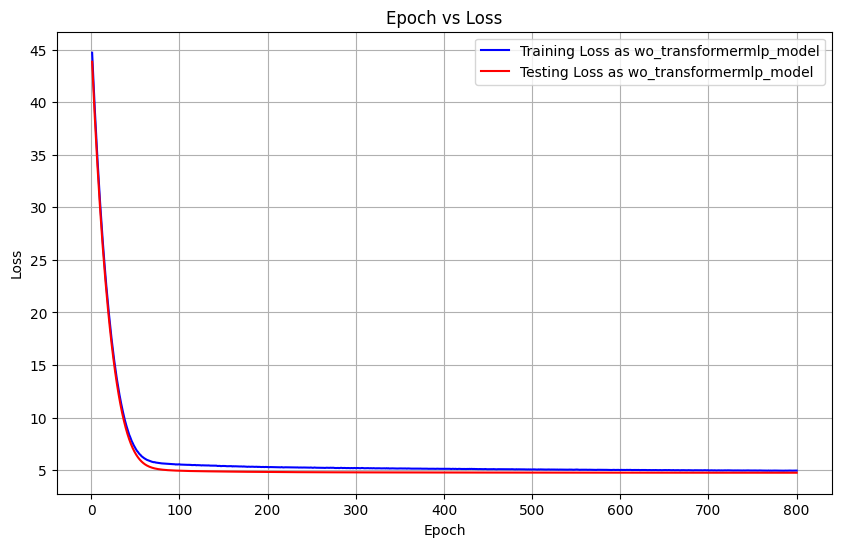

Test Loss: 4.75455888112386
Correlation between actual labels and predicted values at wo_transformermlp_model: 0.4715056170928901
Mean Absolute Error (MAE) at wo_transformermlp_model: 1.7222754955291748


Training model wo_transformer_model: 100%|██████████| 800/800 [1:38:58<00:00,  7.42s/it, test_loss=2.2197, train_loss=2.5365]


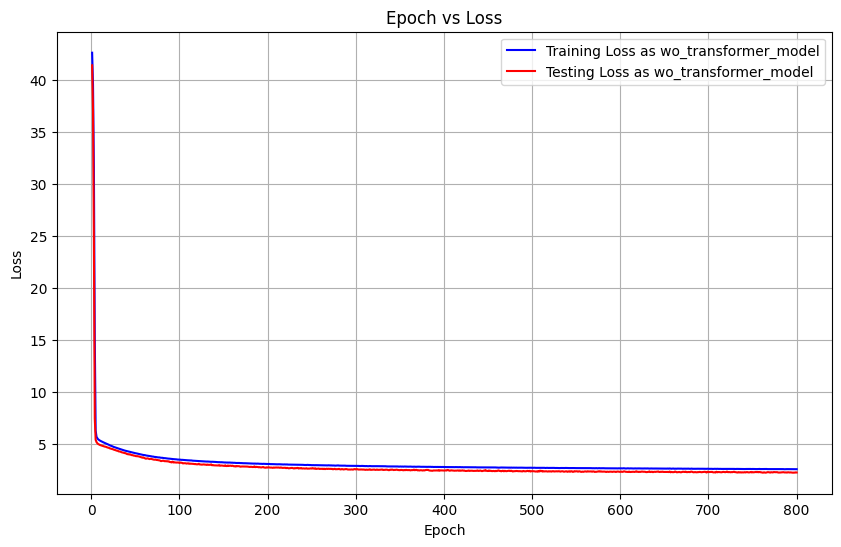

Test Loss: 2.198308324813843
Correlation between actual labels and predicted values at wo_transformer_model: 0.8066993338053224
Mean Absolute Error (MAE) at wo_transformer_model: 1.0117852687835693


Training model wo_mlp_model: 100%|██████████| 800/800 [2:06:41<00:00,  9.50s/it, test_loss=1.6654, train_loss=1.5465]   


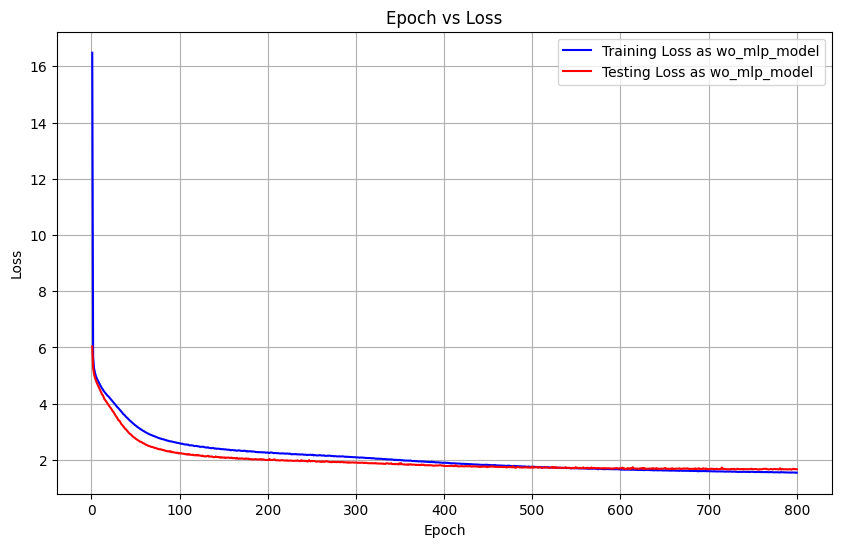

Test Loss: 1.6543726841608684
Correlation between actual labels and predicted values at wo_mlp_model: 0.8715826108283686
Mean Absolute Error (MAE) at wo_mlp_model: 0.8766353726387024


Training model wo_seblock_model: 100%|██████████| 800/800 [2:54:20<00:00, 13.08s/it, test_loss=1.7648, train_loss=1.7891]    


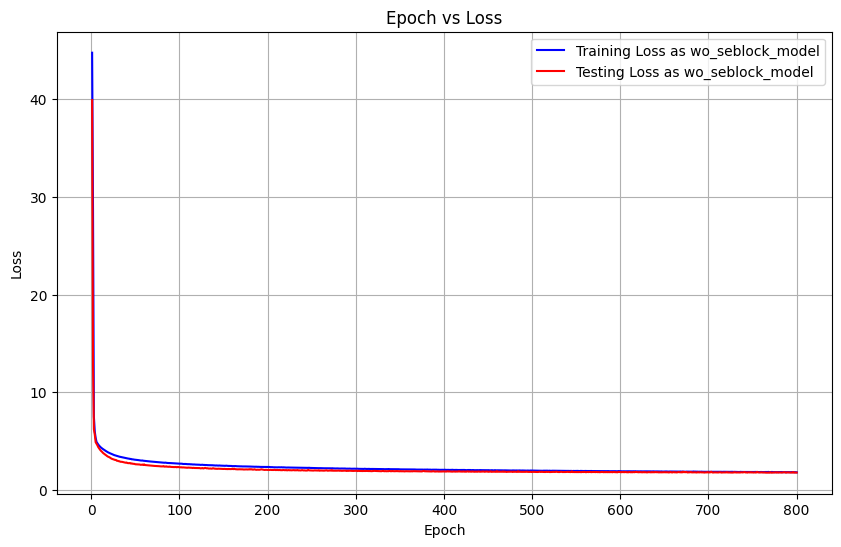

Test Loss: 1.7480923732121785
Correlation between actual labels and predicted values at wo_seblock_model: 0.8525051861720873
Mean Absolute Error (MAE) at wo_seblock_model: 0.8737391829490662


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
import torch
# import ace_tools as tools

# 复制变量，确保原数据不受影响
y_test_tensor_cpu = y_test_tensor.cpu().numpy().copy()
X_test_tensor_scatter_preds_copy = X_test_tensor_scatter_preds.copy()
X_test_tensor_copy = X_test_tensor.cpu().numpy().copy()

# 计算误差
feature_names = result['feature'].tolist()
df_test = pd.DataFrame(X_test_tensor_copy, columns=feature_names)
df_test['y_true'] = y_test_tensor_cpu
df_test['y_pred'] = X_test_tensor_scatter_preds_copy
df_test['error'] = np.abs(df_test['y_true'] - df_test['y_pred'])

median_error = np.median(df_test['error'])
low_error_samples = df_test[df_test['error'] <= median_error]
high_error_samples = df_test[df_test['error'] > median_error]

# 计算特征统计信息
feature_stats = []
for col in feature_names:
    mean_low = low_error_samples[col].mean()
    mean_high = high_error_samples[col].mean()
    p_value = ttest_ind(low_error_samples[col], high_error_samples[col], equal_var=False).pvalue
    feature_stats.append([col, mean_low, mean_high, p_value])

feature_analysis = pd.DataFrame(feature_stats, columns=['Feature', 'Mean_Low_Error', 'Mean_High_Error', 'P_Value'])

# 显示特征分析结果
tools.display_dataframe_to_user("Feature Analysis", feature_analysis)

# 训练决策树分析特征重要性
X = df_test[feature_names].copy()
y = df_test['error'].copy()
regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
regressor.fit(X, y)
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': regressor.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# PCA降维
df_test_pca = PCA(n_components=2).fit_transform(X)
df_test['PCA1'], df_test['PCA2'] = df_test_pca[:, 0], df_test_pca[:, 1]

# 绘制 PCA 结果
plt.figure(figsize=(8, 6))
plt.scatter(df_test[df_test['error'] <= median_error]['PCA1'], df_test[df_test['error'] <= median_error]['PCA2'], label='Low Error', alpha=0.5)
plt.scatter(df_test[df_test['error'] > median_error]['PCA1'], df_test[df_test['error'] > median_error]['PCA2'], label='High Error', alpha=0.5, color='red')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Low and High Error Samples')
plt.legend()
plt.show()

Defaulting to user installation because normal site-packages is not writeable


ValueError: Shape of passed values is (61123, 212), indices imply (61123, 77)